In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to determine the most voted
import collections 

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')

def show_batch(image_batch, label_batch):
    columns = 6
    rows = BATCH_SIZE / columns + 1  
    plt.figure(figsize=(10, 2 * rows))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(int(rows), columns, n+1)
        plt.imshow((image_batch[n]))
        plt.title(classNames[label_batch[n]==1][0])
        plt.axis('off')
        


In [3]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

In [4]:
BATCH_SIZE = 128
IMAGE_SIZE = 32
NUM_MODELS = 3

In [5]:
data_dir = pathlib.Path('Final_Training/Images/')
  
classNames = np.array(os.listdir(data_dir))
NUM_CLASSES = len(classNames)
classNames

array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files("Final_Training/Images/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

t = next(iter(dataset))
print(t[0].shape, t[1].shape)

dataset_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", dataset_length) 

(32, 32, 3) (43,)
Total images in dataset:  27930


In [7]:
val_listset = tf.data.Dataset.list_files("Final_Validation/Images/*/*.png")
val_dataset_length = val_listset.cardinality().numpy()
print("Total images in validatation dataset: ", val_dataset_length)

valset = val_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
valset = valset.cache()
valset = valset.shuffle(buffer_size = val_dataset_length)
valset = valset.batch(batch_size = BATCH_SIZE)
valset = valset.prefetch(buffer_size = AUTOTUNE)


test_listset = tf.data.Dataset.list_files("Final_Test/Images/*/*.png")
test_dataset_length = test_listset.cardinality().numpy()
print("Total images in test dataset: ", test_dataset_length)

testset = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size = BATCH_SIZE)

Total images in validatation dataset:  11280
Total images in test dataset:  12630


In [11]:
def create_model(classCount, imgSize, channels):

    modelLogits = Sequential()
    
    modelLogits.add(Conv2D(128, (5, 5),
                input_shape=(imgSize, imgSize, channels)))         
    modelLogits.add(LeakyReLU(alpha=0.01))  
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 

    modelLogits.add(Conv2D(196, (5, 5) )) 
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 

    modelLogits.add(Conv2D(256, (5, 5) ) )   
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 
    
    modelLogits.add(Flatten())
    modelLogits.add(Dense(384))
    modelLogits.add(LeakyReLU(alpha=0.0))             
    modelLogits.add(Dropout(0.5)) 
    
    modelLogits.add(Dense(classCount))
    
    output = Activation('softmax')(modelLogits.output)

    model = tf.keras.Model(modelLogits.inputs, output)
    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model, modelLogits


### Data augmentation functions

In [12]:
import tensorflow_addons as tfa

def process_brightness(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):
    
    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):
    
    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):
    
    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [32,32])
    return img, label

from noise import pnoise2, snoise2
perlin_freq = 1024

def add_perlin_noise(image, label):
    
    perlin = np.empty((IMAGE_SIZE,IMAGE_SIZE),dtype=np.float32)
    for y in range(IMAGE_SIZE):
        for x in range(IMAGE_SIZE):
            perlin[y][x] = pnoise2(x / perlin_freq, y / perlin_freq, 4)

    max = np.amax(perlin)
    min = np.amin(perlin)
    max -= min
    perlin -= min
    perlin /= max
    noise = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3 ))
    noise[:,:,0] = perlin # same value in each channel
    noise[:,:,1] = perlin
    noise[:,:,2] = perlin

    img = tf.add(image, noise)
    return img, label

def add_gaussian_noise(image, label):
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(25)/(255), dtype=tf.float32)
        noise_img = image + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img, label

### Ensemble functions

In [13]:
def train_models(train, val,file_path_prefix, new_length):
    models = []
    histories = []
    
    for i in range(NUM_MODELS):

        model, modelL = create_model(NUM_CLASSES,IMAGE_SIZE,3)

        callbacks = prepare_callbacks(f'{file_path_prefix}_{i:02}/cp.ckpt')
        
        hist = model.fit(train, steps_per_epoch = new_length / BATCH_SIZE,
                              epochs=100, 
                              validation_data = val, 
                              callbacks = callbacks)

        models.append([model, modelL])
        histories.append(hist)
    
    return models,histories


def create_models():

    models = []
    
    for i in range(NUM_MODELS):
        model, modelL = create_model(NUM_CLASSES,IMAGE_SIZE,3)
        models.append([model, modelL])

    return models


def load_weights(models, file_path_prefix):
    for i in range(NUM_MODELS):
        file_path = f'{file_path_prefix}_{i:02}/cp.ckpt'
        models[i][0].load_weights(file_path)
        models[i][0].save('ensemble/temp.hdf5')
        models[i][1].load_weights('ensemble/temp.hdf5', by_name = True)


def evaluate_models(models):
    
    accuracy = 0
    
    for i in range(NUM_MODELS):
        eval = models[i][0].evaluate(testset, verbose = 2)
        accuracy += eval[1]
        
    print(f'average accuracy: {(accuracy/NUM_MODELS)*100:.3f}')

    
def get_labels_logits_and_preds(models):

    preds = [[] for _ in range(NUM_MODELS) ]
    logits = [[] for _ in range(NUM_MODELS)]
    labels = []
    for images, labs in testset.take(-1):

        labels.extend(labs.numpy())
        for i in range(NUM_MODELS):

            preds[i].extend(models[i][0].predict(images))
            logits[i].extend(models[i][1].predict(images))

    labels = [np.argmax(i) for i in labels]  
    
    return labels, logits, preds


def get_class_preds(preds):

    class_preds = []

    for i in range(test_dataset_length):

        c = []
        for m in range(NUM_MODELS):

            c.append(np.argmax(preds[m][i]))
        class_preds.append(c)
        
    return class_preds


def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(test_dataset_length):

        log = logits[0][i]
        for m in range(1, NUM_MODELS):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)


def get_stats(labels, class_preds, class_logits):

    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0
    log_ok = 0
    log_ko = 0

    for k in range(test_dataset_length):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1
        if class_logits[k] == labels[k]:
            log_ok += 1
        else:
            log_ko += 1
        count += 1 
        
    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko]

def train_print_results(version, dataV):
    file_path_prefix = f'ensemble/model_{version}'
    models_V, histories_V = train_models(dataV, valset, file_path_prefix, dataset_updated_length)

    load_weights(models_V, file_path_prefix)
    evaluate_models(models_V)
    labels_V, logits_V, preds_V = get_labels_logits_and_preds(models_V)
    class_preds_V = get_class_preds(preds_V)
    class_logits_V = get_class_from_sum_of_logits(logits_V)


    res = get_stats(labels_V, class_preds_V, class_logits_V)
    print('[count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko], accuracy')
    print(res, res[6]/res[0])

    return models_V, histories_V

### Dataset augmentation

In [15]:
dataV1 = dataset
# color ops
dataV1 = dataV1.map(process_brightness)
dataV1 = dataV1.concatenate(dataset.map(process_contrast))
dataV1 = dataV1.concatenate(dataset.map(process_hue))
dataV1 = dataV1.concatenate(dataset.map(process_saturation))

#geometry ops
dataV1 = dataV1.concatenate(dataset.map(process_rotate))
dataV1 = dataV1.concatenate(dataset.map(process_shear))
dataV1 = dataV1.concatenate(dataset.map(process_translate))
dataV1 = dataV1.concatenate(dataset.map(process_crop))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 8

dataV1 = dataV1.cache()
dataV1 = dataV1.shuffle(buffer_size = (dataset_updated_length))
dataV1 = dataV1.batch(batch_size = BATCH_SIZE)
dataV1 = dataV1.prefetch(buffer_size = AUTOTUNE)
dataV1 = dataV1.repeat()

In [16]:
file_path_prefix = 'ensemble/model_V1'
models_V1, histories_V1 = train_models(dataV1, valset, file_path_prefix, dataset_updated_length)

Epoch 1/100
1745/1745 [==============================] - 82s 28ms/step - loss: 2.3125 - accuracy: 0.4608 - val_loss: 0.1495 - val_accuracy: 0.9616

Epoch 00001: val_accuracy improved from -inf to 0.96161, saving model to ensemble/model_V1_00\cp.ckpt
Epoch 2/100
1745/1745 [==============================] - 50s 28ms/step - loss: 0.4386 - accuracy: 0.8766 - val_loss: 0.0720 - val_accuracy: 0.9787

Epoch 00002: val_accuracy improved from 0.96161 to 0.97872, saving model to ensemble/model_V1_00\cp.ckpt
Epoch 3/100
1745/1745 [==============================] - 47s 27ms/step - loss: 0.2204 - accuracy: 0.9359 - val_loss: 0.0445 - val_accuracy: 0.9869

Epoch 00003: val_accuracy improved from 0.97872 to 0.98688, saving model to ensemble/model_V1_00\cp.ckpt
Epoch 4/100
1745/1745 [==============================] - 49s 28ms/step - loss: 0.1350 - accuracy: 0.9605 - val_loss: 0.0344 - val_accuracy: 0.9903

Epoch 00004: val_accuracy improved from 0.98688 to 0.99034, saving model to ensemble/model_V1_00

In [17]:
load_weights(models_V1, file_path_prefix)
evaluate_models(models_V1)
labels_V1, logits_V1, preds_V1 = get_labels_logits_and_preds(models_V1)
class_preds_V1 = get_class_preds(preds_V1)
class_logits_V1 = get_class_from_sum_of_logits(logits_V1)    


99/99 - 2s - loss: 0.0226 - accuracy: 0.9948
99/99 - 2s - loss: 0.0241 - accuracy: 0.9937
99/99 - 1s - loss: 0.0271 - accuracy: 0.9924
average accuracy: 99.364


In [18]:
res = get_stats(labels_V1, class_preds_V1, class_logits_V1)
print('[count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko], accuracy')
print(res, res[6]/res[0])

[count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko], accuracy
[12630, 12494, 27, 69, 3, 37, 12570, 60] 0.995249406175772


In [27]:
def add_gaussian(image, label):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1, dtype=tf.float32)
    img = tf.add(image, noise)
    return img, label

dataV2 = dataset
# color ops
dataV2 = dataV2.map(process_brightness)
dataV2 = dataV2.concatenate(dataset.map(process_contrast))
dataV2 = dataV2.concatenate(dataset.map(process_hue))
dataV2 = dataV2.concatenate(dataset.map(process_saturation))

#geometry ops
dataV2 = dataV2.concatenate(dataset.map(process_rotate))
dataV2 = dataV2.concatenate(dataset.map(process_shear))
dataV2 = dataV2.concatenate(dataset.map(process_translate))
dataV2 = dataV2.concatenate(dataset.map(process_crop))

#noise
dataV2 = dataV2.concatenate(dataset.map(add_gaussian))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 9

dataV2 = dataV2.cache()
dataV2 = dataV2.shuffle(buffer_size = (dataset_updated_length))
dataV2 = dataV2.batch(batch_size = BATCH_SIZE)
dataV2 = dataV2.prefetch(buffer_size = AUTOTUNE)
dataV2 = dataV2.repeat()


In [28]:
file_path_prefix = 'ensemble/model_V2'
models_V2, histories_V2 = train_models(dataV2, valset, file_path_prefix, dataset_updated_length)

load_weights(models_V2, file_path_prefix)
evaluate_models(models_V2)
labels_V2, logits_V2, preds_V2 = get_labels_logits_and_preds(models_V2)
class_preds_V2 = get_class_preds(preds_V2)
class_logits_V2 = get_class_from_sum_of_logits(logits_V2)


res = get_stats(labels_V2, class_preds_V2, class_logits_V2)
print('[count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko], accuracy')
print(res, res[6]/res[0])

Epoch 1/100
1963/1963 [==============================] - 92s 26ms/step - loss: 2.7068 - accuracy: 0.3680 - val_loss: 0.1971 - val_accuracy: 0.9425

Epoch 00001: val_accuracy improved from -inf to 0.94246, saving model to ensemble/model_V2_00\cp.ckpt
Epoch 2/100
1963/1963 [==============================] - 53s 27ms/step - loss: 0.7989 - accuracy: 0.7833 - val_loss: 0.0976 - val_accuracy: 0.9696

Epoch 00002: val_accuracy improved from 0.94246 to 0.96959, saving model to ensemble/model_V2_00\cp.ckpt
Epoch 3/100
1963/1963 [==============================] - 53s 27ms/step - loss: 0.5441 - accuracy: 0.8498 - val_loss: 0.0664 - val_accuracy: 0.9791

Epoch 00003: val_accuracy improved from 0.96959 to 0.97908, saving model to ensemble/model_V2_00\cp.ckpt
Epoch 4/100
1963/1963 [==============================] - 53s 27ms/step - loss: 0.4372 - accuracy: 0.8774 - val_loss: 0.0450 - val_accuracy: 0.9865

Epoch 00004: val_accuracy improved from 0.97908 to 0.98652, saving model to ensemble/model_V2_00

In [31]:
dataV3 = dataset
# color ops
dataV3 = dataV3.concatenate(dataset.map(process_brightness))
dataV3 = dataV3.concatenate(dataset.map(process_contrast))
dataV3 = dataV3.concatenate(dataset.map(process_hue))
dataV3 = dataV3.concatenate(dataset.map(process_saturation))

#geometry ops
dataV3 = dataV3.concatenate(dataset.map(process_rotate))
dataV3 = dataV3.concatenate(dataset.map(process_shear))
dataV3 = dataV3.concatenate(dataset.map(process_translate))
dataV3 = dataV3.concatenate(dataset.map(process_crop))


# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 9

dataV3 = dataV3.cache()
dataV3 = dataV3.shuffle(buffer_size = (dataset_updated_length))
dataV3 = dataV3.batch(batch_size = BATCH_SIZE)
dataV3 = dataV3.prefetch(buffer_size = AUTOTUNE)
dataV3 = dataV3.repeat()

In [32]:
file_path_prefix = 'ensemble/model_V3'
models_V3, histories_V3 = train_models(dataV3, valset, file_path_prefix, dataset_updated_length)

load_weights(models_V3, file_path_prefix)
evaluate_models(models_V3)
labels_V3, logits_V3, preds_V3 = get_labels_logits_and_preds(models_V3)
class_preds_V3 = get_class_preds(preds_V3)
class_logits_V3 = get_class_from_sum_of_logits(logits_V3)


res = get_stats(labels_V3, class_preds_V3, class_logits_V3)
print('[count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko], accuracy')
print(res, res[6]/res[0])

Epoch 1/100
1963/1963 [==============================] - 78s 22ms/step - loss: 2.1237 - accuracy: 0.5023 - val_loss: 0.1206 - val_accuracy: 0.9643

Epoch 00001: val_accuracy improved from -inf to 0.96427, saving model to ensemble/model_V3_00\cp.ckpt
Epoch 2/100
1963/1963 [==============================] - 43s 22ms/step - loss: 0.3561 - accuracy: 0.8991 - val_loss: 0.0601 - val_accuracy: 0.9817

Epoch 00002: val_accuracy improved from 0.96427 to 0.98174, saving model to ensemble/model_V3_00\cp.ckpt
Epoch 3/100
1963/1963 [==============================] - 43s 22ms/step - loss: 0.1753 - accuracy: 0.9497 - val_loss: 0.0422 - val_accuracy: 0.9862

Epoch 00003: val_accuracy improved from 0.98174 to 0.98617, saving model to ensemble/model_V3_00\cp.ckpt
Epoch 4/100
1963/1963 [==============================] - 43s 22ms/step - loss: 0.1099 - accuracy: 0.9680 - val_loss: 0.0304 - val_accuracy: 0.9910

Epoch 00004: val_accuracy improved from 0.98617 to 0.99096, saving model to ensemble/model_V3_00

In [69]:
from noise import pnoise2, snoise2
perlin_freq = 1024

def add_perlin_noise(image, label):
    
    perlin = np.empty((IMAGE_SIZE,IMAGE_SIZE),dtype=np.float32)
    for y in range(IMAGE_SIZE):
        for x in range(IMAGE_SIZE):
            perlin[y][x] = pnoise2(x / perlin_freq, y / perlin_freq, 4)

    max = np.amax(perlin)
    min = np.amin(perlin)
    max -= min
    perlin -= min
    perlin /= max
    noise = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3 ))
    noise[:,:,0] = perlin # same value in each channel
    noise[:,:,1] = perlin
    noise[:,:,2] = perlin

    img = tf.add(image, noise)
    return img, label

In [70]:
dataV4 = dataset
# color ops
dataV4 = dataV4.map(process_brightness)
dataV4 = dataV4.concatenate(dataset.map(process_contrast))
dataV4 = dataV4.concatenate(dataset.map(process_hue))
dataV4 = dataV4.concatenate(dataset.map(process_saturation))

#geometry ops
dataV4 = dataV4.concatenate(dataset.map(process_rotate))
dataV4 = dataV4.concatenate(dataset.map(process_shear))
dataV4 = dataV4.concatenate(dataset.map(process_translate))
dataV4 = dataV4.concatenate(dataset.map(process_crop))

#noise
perlin_freq = 1024
dataV4 = dataV4.concatenate(dataset.map(add_perlin_noise))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 9

dataV4 = dataV4.cache()
dataV4 = dataV4.shuffle(buffer_size = (dataset_updated_length))
dataV4 = dataV4.batch(batch_size = BATCH_SIZE)
dataV4 = dataV4.prefetch(buffer_size = AUTOTUNE)
dataV4 = dataV4.repeat()


In [73]:
def train_print_results(version, dataV):
    file_path_prefix = f'ensemble/model_{version}'
    models_V, histories_V = train_models(dataV, valset, file_path_prefix, dataset_updated_length)

    load_weights(models_V, file_path_prefix)
    evaluate_models(models_V)
    labels_V, logits_V, preds_V = get_labels_logits_and_preds(models_V)
    class_preds_V = get_class_preds(preds_V)
    class_logits_V = get_class_from_sum_of_logits(logits_V)


    res = get_stats(labels_V, class_preds_V, class_logits_V)
    print('[count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko], accuracy')
    print(res, res[6]/res[0])

    return models_V, histories_V


models_V4, histories_V4 = train_print_results('V4', dataV4)

In [74]:
dataV5 = dataset
# color ops
dataV5 = dataV5.map(process_brightness)
dataV5 = dataV5.concatenate(dataset.map(process_contrast))
dataV5 = dataV5.concatenate(dataset.map(process_hue))
dataV5 = dataV5.concatenate(dataset.map(process_saturation))

#geometry ops
dataV5 = dataV5.concatenate(dataset.map(process_rotate))
dataV5 = dataV5.concatenate(dataset.map(process_shear))
dataV5 = dataV5.concatenate(dataset.map(process_translate))
dataV5 = dataV5.concatenate(dataset.map(process_crop))

#noise
perlin_freq = 512
dataV5 = dataV5.concatenate(dataset.map(add_perlin_noise))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 9

dataV5 = dataV5.cache()
dataV5 = dataV5.shuffle(buffer_size = (dataset_updated_length))
dataV5 = dataV5.batch(batch_size = BATCH_SIZE)
dataV5 = dataV5.prefetch(buffer_size = AUTOTUNE)
dataV5 = dataV5.repeat()

In [75]:
%%time
models_V5, histories_V5 = train_print_results('V5', dataV5)

Epoch 1/100
1963/1963 [==============================] - 90s 25ms/step - loss: 2.2974 - accuracy: 0.4652 - val_loss: 0.1291 - val_accuracy: 0.9609

Epoch 00001: val_accuracy improved from -inf to 0.96090, saving model to ensemble/model_V5_00\cp.ckpt
Epoch 2/100
1963/1963 [==============================] - 49s 25ms/step - loss: 0.3837 - accuracy: 0.8919 - val_loss: 0.0596 - val_accuracy: 0.9807

Epoch 00002: val_accuracy improved from 0.96090 to 0.98067, saving model to ensemble/model_V5_00\cp.ckpt
Epoch 3/100
1963/1963 [==============================] - 51s 26ms/step - loss: 0.1911 - accuracy: 0.9448 - val_loss: 0.0332 - val_accuracy: 0.9887

Epoch 00003: val_accuracy improved from 0.98067 to 0.98874, saving model to ensemble/model_V5_00\cp.ckpt
Epoch 4/100
1963/1963 [==============================] - 50s 25ms/step - loss: 0.1201 - accuracy: 0.9651 - val_loss: 0.0253 - val_accuracy: 0.9929

Epoch 00004: val_accuracy improved from 0.98874 to 0.99291, saving model to ensemble/model_V5_00

In [76]:
dataV6 = dataset
# color ops
dataV6 = dataV6.map(process_brightness)
dataV6 = dataV6.concatenate(dataset.map(process_contrast))
dataV6 = dataV6.concatenate(dataset.map(process_hue))
dataV6 = dataV6.concatenate(dataset.map(process_saturation))

#geometry ops
dataV6 = dataV6.concatenate(dataset.map(process_rotate))
dataV6 = dataV6.concatenate(dataset.map(process_shear))
dataV6 = dataV6.concatenate(dataset.map(process_translate))
dataV6 = dataV6.concatenate(dataset.map(process_crop))

#noise
perlin_freq = 2048
dataV6 = dataV6.concatenate(dataset.map(add_perlin_noise))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 9

dataV6 = dataV6.cache()
dataV6 = dataV6.shuffle(buffer_size = (dataset_updated_length))
dataV6 = dataV6.batch(batch_size = BATCH_SIZE)
dataV6 = dataV6.prefetch(buffer_size = AUTOTUNE)
dataV6 = dataV6.repeat()

In [77]:

%%time
models_V6, histories_V6 = train_print_results('V6', dataV6)

Epoch 1/100
1963/1963 [==============================] - 85s 22ms/step - loss: 2.2052 - accuracy: 0.4863 - val_loss: 0.1351 - val_accuracy: 0.9624

Epoch 00001: val_accuracy improved from -inf to 0.96241, saving model to ensemble/model_V6_00\cp.ckpt
Epoch 2/100
1963/1963 [==============================] - 44s 22ms/step - loss: 0.3745 - accuracy: 0.8956 - val_loss: 0.0598 - val_accuracy: 0.9812

Epoch 00002: val_accuracy improved from 0.96241 to 0.98121, saving model to ensemble/model_V6_00\cp.ckpt
Epoch 3/100
1963/1963 [==============================] - 44s 22ms/step - loss: 0.1889 - accuracy: 0.9456 - val_loss: 0.0369 - val_accuracy: 0.9887

Epoch 00003: val_accuracy improved from 0.98121 to 0.98874, saving model to ensemble/model_V6_00\cp.ckpt
Epoch 4/100
1963/1963 [==============================] - 44s 22ms/step - loss: 0.1187 - accuracy: 0.9648 - val_loss: 0.0307 - val_accuracy: 0.9907

Epoch 00004: val_accuracy improved from 0.98874 to 0.99069, saving model to ensemble/model_V6_00

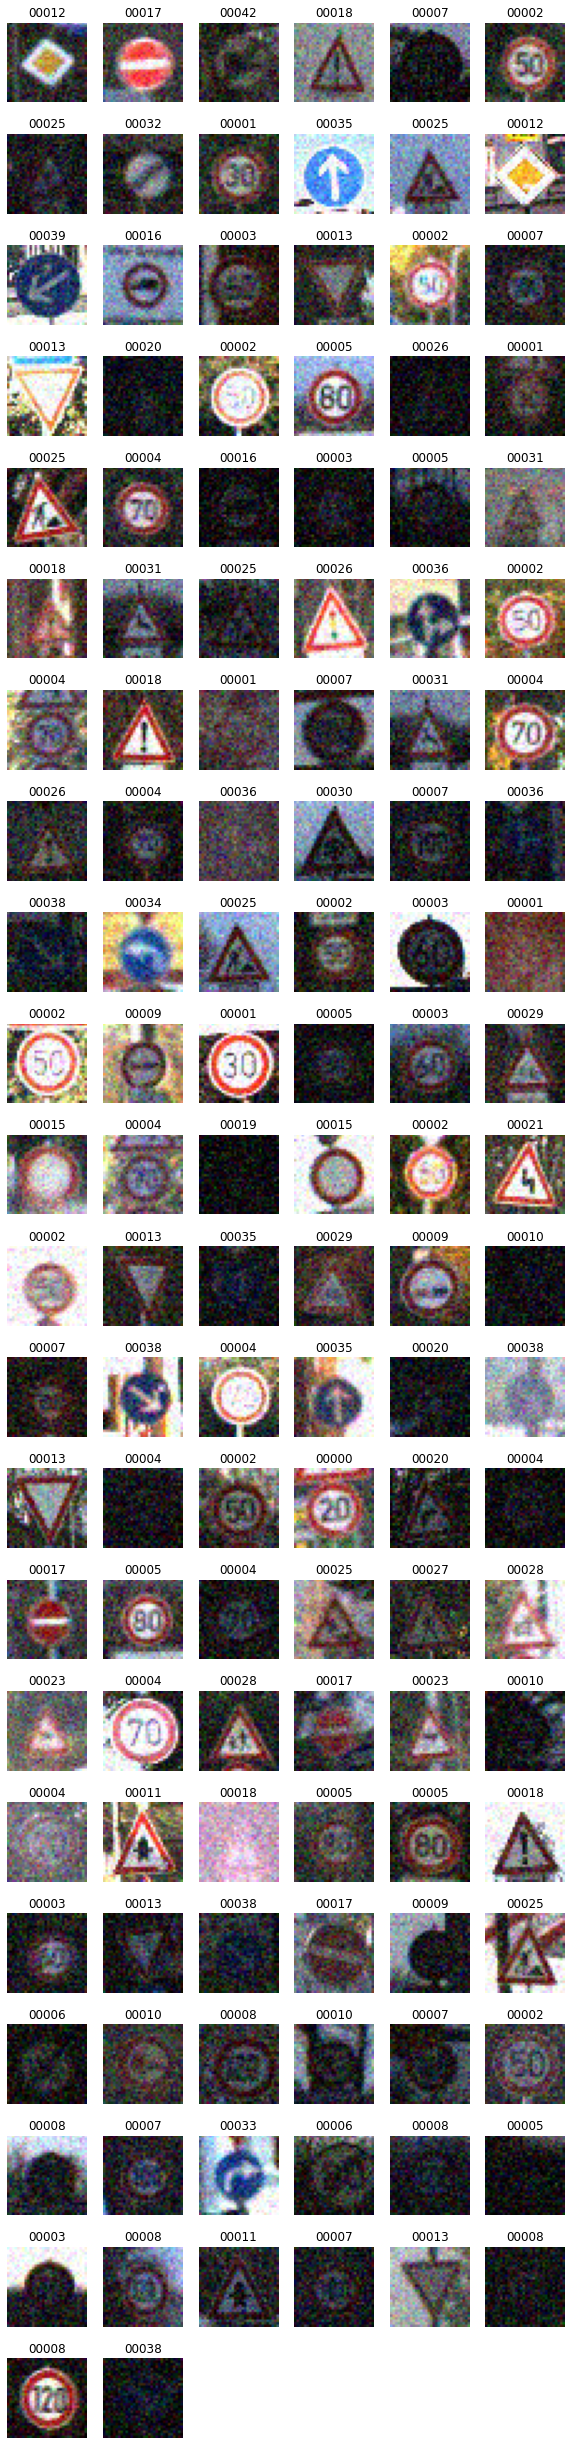

In [89]:
def add_gaussian_noise(image, label):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(25)/(255), dtype=tf.float32)
        noise_img = image + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img, label


In [90]:
dataV7 = dataset
# color ops
dataV7 = dataV7.map(process_brightness)
dataV7 = dataV7.concatenate(dataset.map(process_contrast))
dataV7 = dataV7.concatenate(dataset.map(process_hue))
dataV7 = dataV7.concatenate(dataset.map(process_saturation))

#geometry ops
dataV7 = dataV7.concatenate(dataset.map(process_rotate))
dataV7 = dataV7.concatenate(dataset.map(process_shear))
dataV7 = dataV7.concatenate(dataset.map(process_translate))
dataV7 = dataV7.concatenate(dataset.map(process_crop))

#noise
perlin_freq = 1024
#dataV7 = dataV7.concatenate(dataset.map(add_perlin_noise))
dataV7 = dataV7.concatenate(dataset.map(add_gaussian_noise))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 9

dataV7 = dataV7.cache()
dataV7 = dataV7.shuffle(buffer_size = (dataset_updated_length))
dataV7 = dataV7.batch(batch_size = BATCH_SIZE)
dataV7 = dataV7.prefetch(buffer_size = AUTOTUNE)
dataV7 = dataV7.repeat()

In [91]:
%%time
models_V7, histories_V7 = train_print_results('V7', dataV7)

Epoch 1/100
1963/1963 [==============================] - 93s 25ms/step - loss: 2.2203 - accuracy: 0.4832 - val_loss: 0.1395 - val_accuracy: 0.9635

Epoch 00001: val_accuracy improved from -inf to 0.96348, saving model to ensemble/model_V7_00\cp.ckpt
Epoch 2/100
1963/1963 [==============================] - 47s 24ms/step - loss: 0.4042 - accuracy: 0.8850 - val_loss: 0.0648 - val_accuracy: 0.9827

Epoch 00002: val_accuracy improved from 0.96348 to 0.98271, saving model to ensemble/model_V7_00\cp.ckpt
Epoch 3/100
1963/1963 [==============================] - 48s 24ms/step - loss: 0.2131 - accuracy: 0.9389 - val_loss: 0.0385 - val_accuracy: 0.9889

Epoch 00003: val_accuracy improved from 0.98271 to 0.98892, saving model to ensemble/model_V7_00\cp.ckpt
Epoch 4/100
1963/1963 [==============================] - 53s 27ms/step - loss: 0.1433 - accuracy: 0.9578 - val_loss: 0.0319 - val_accuracy: 0.9910

Epoch 00004: val_accuracy improved from 0.98892 to 0.99105, saving model to ensemble/model_V7_00

In [92]:
def add_gaussian_noise(image, label):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(50)/(255), dtype=tf.float32)
        noise_img = image + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img, label

dataV8 = dataset
# color ops
dataV8 = dataV8.map(process_brightness)
dataV8 = dataV8.concatenate(dataset.map(process_contrast))
dataV8 = dataV8.concatenate(dataset.map(process_hue))
dataV8 = dataV8.concatenate(dataset.map(process_saturation))

#geometry ops
dataV8 = dataV8.concatenate(dataset.map(process_rotate))
dataV8 = dataV8.concatenate(dataset.map(process_shear))
dataV8 = dataV8.concatenate(dataset.map(process_translate))
dataV8 = dataV8.concatenate(dataset.map(process_crop))

#noise
dataV8 = dataV8.concatenate(dataset.map(add_gaussian_noise))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 9

dataV8 = dataV8.cache()
dataV8 = dataV8.shuffle(buffer_size = (dataset_updated_length))
dataV8 = dataV8.batch(batch_size = BATCH_SIZE)
dataV8 = dataV8.prefetch(buffer_size = AUTOTUNE)
dataV8 = dataV8.repeat()

In [93]:
%%time
models_V8, histories_V8 = train_print_results('V8', dataV8)

Epoch 1/100
1963/1963 [==============================] - 106s 30ms/step - loss: 2.2215 - accuracy: 0.4766 - val_loss: 0.1526 - val_accuracy: 0.9577

Epoch 00001: val_accuracy improved from -inf to 0.95771, saving model to ensemble/model_V8_00\cp.ckpt
Epoch 2/100
1963/1963 [==============================] - 56s 28ms/step - loss: 0.4822 - accuracy: 0.8642 - val_loss: 0.0701 - val_accuracy: 0.9799

Epoch 00002: val_accuracy improved from 0.95771 to 0.97988, saving model to ensemble/model_V8_00\cp.ckpt
Epoch 3/100
1963/1963 [==============================] - 49s 25ms/step - loss: 0.2757 - accuracy: 0.9209 - val_loss: 0.0510 - val_accuracy: 0.9841

Epoch 00003: val_accuracy improved from 0.97988 to 0.98413, saving model to ensemble/model_V8_00\cp.ckpt
Epoch 4/100
1963/1963 [==============================] - 50s 25ms/step - loss: 0.1915 - accuracy: 0.9439 - val_loss: 0.0320 - val_accuracy: 0.9913

Epoch 00004: val_accuracy improved from 0.98413 to 0.99131, saving model to ensemble/model_V8_0

In [99]:
def add_gaussian_noise(image, label):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(75)/(255), dtype=tf.float32)
        noise_img = image + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img, label

dataV9 = dataset
# color ops
dataV9 = dataV9.map(process_brightness)
dataV9 = dataV9.concatenate(dataset.map(process_contrast))
dataV9 = dataV9.concatenate(dataset.map(process_hue))
dataV9 = dataV9.concatenate(dataset.map(process_saturation))

#geometry ops
dataV9 = dataV9.concatenate(dataset.map(process_rotate))
dataV9 = dataV9.concatenate(dataset.map(process_shear))
dataV9 = dataV9.concatenate(dataset.map(process_translate))
dataV9 = dataV9.concatenate(dataset.map(process_crop))

#noise
dataV9 = dataV9.concatenate(dataset.map(add_gaussian_noise))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 9

dataV9 = dataV9.cache()
dataV9 = dataV9.shuffle(buffer_size = (dataset_updated_length))
dataV9 = dataV9.batch(batch_size = BATCH_SIZE)
dataV9 = dataV9.prefetch(buffer_size = AUTOTUNE)
dataV9 = dataV9.repeat()

In [100]:
%%time
models_V9, histories_V9 = train_print_results('V9', dataV9)

Epoch 1/100
1963/1963 [==============================] - 94s 23ms/step - loss: 2.3480 - accuracy: 0.4574 - val_loss: 0.1614 - val_accuracy: 0.9535

Epoch 00001: val_accuracy improved from -inf to 0.95355, saving model to ensemble/model_V9_00\cp.ckpt
Epoch 2/100
1963/1963 [==============================] - 43s 22ms/step - loss: 0.5343 - accuracy: 0.8504 - val_loss: 0.0816 - val_accuracy: 0.9755

Epoch 00002: val_accuracy improved from 0.95355 to 0.97553, saving model to ensemble/model_V9_00\cp.ckpt
Epoch 3/100
1963/1963 [==============================] - 44s 22ms/step - loss: 0.3406 - accuracy: 0.9030 - val_loss: 0.0602 - val_accuracy: 0.9808

Epoch 00003: val_accuracy improved from 0.97553 to 0.98076, saving model to ensemble/model_V9_00\cp.ckpt
Epoch 4/100
1963/1963 [==============================] - 43s 22ms/step - loss: 0.2464 - accuracy: 0.9282 - val_loss: 0.0399 - val_accuracy: 0.9877

Epoch 00004: val_accuracy improved from 0.98076 to 0.98768, saving model to ensemble/model_V9_00

In [101]:
def add_gaussian_noise(image, label):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(50)/(255), dtype=tf.float32)
        noise_img = image + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img, label

dataV10 = dataset
# color ops
dataV10 = dataV10.map(process_brightness)
dataV10 = dataV10.concatenate(dataset.map(process_contrast))
dataV10 = dataV10.concatenate(dataset.map(process_hue))
dataV10 = dataV10.concatenate(dataset.map(process_saturation))

#geometry ops
dataV10 = dataV10.concatenate(dataset.map(process_rotate))
dataV10 = dataV10.concatenate(dataset.map(process_shear))
dataV10 = dataV10.concatenate(dataset.map(process_translate))
dataV10 = dataV10.concatenate(dataset.map(process_crop))

#noise
perlin_freq = 1024
dataV10 = dataV10.concatenate(dataset.map(add_perlin_noise))
dataV10 = dataV10.concatenate(dataset.map(add_gaussian_noise))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 10

dataV10 = dataV10.cache()
dataV10 = dataV10.shuffle(buffer_size = (dataset_updated_length))
dataV10 = dataV10.batch(batch_size = BATCH_SIZE)
dataV10 = dataV10.prefetch(buffer_size = AUTOTUNE)
dataV10 = dataV10.repeat()

In [102]:
%%time
models_V10, histories_V10 = train_print_results('V10', dataV10)

Epoch 1/100
2182/2182 [==============================] - 105s 21ms/step - loss: 2.1961 - accuracy: 0.4879 - val_loss: 0.1306 - val_accuracy: 0.9621

Epoch 00001: val_accuracy improved from -inf to 0.96206, saving model to ensemble/model_V10_00\cp.ckpt
Epoch 2/100
2182/2182 [==============================] - 46s 21ms/step - loss: 0.4270 - accuracy: 0.8810 - val_loss: 0.0660 - val_accuracy: 0.9793

Epoch 00002: val_accuracy improved from 0.96206 to 0.97934, saving model to ensemble/model_V10_00\cp.ckpt
Epoch 3/100
2182/2182 [==============================] - 46s 21ms/step - loss: 0.2470 - accuracy: 0.9289 - val_loss: 0.0423 - val_accuracy: 0.9868

Epoch 00003: val_accuracy improved from 0.97934 to 0.98679, saving model to ensemble/model_V10_00\cp.ckpt
Epoch 4/100
2182/2182 [==============================] - 46s 21ms/step - loss: 0.1767 - accuracy: 0.9484 - val_loss: 0.0338 - val_accuracy: 0.9893

Epoch 00004: val_accuracy improved from 0.98679 to 0.98927, saving model to ensemble/model_V

In [14]:
def add_gaussian_noise(image, label):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(25)/(255), dtype=tf.float32)
        noise_img = image + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img, label

dataV11 = dataset
# color ops
dataV11 = dataV11.map(process_brightness)
dataV11 = dataV11.concatenate(dataset.map(process_contrast))
dataV11 = dataV11.concatenate(dataset.map(process_hue))
dataV11 = dataV11.concatenate(dataset.map(process_saturation))

#geometry ops
dataV11 = dataV11.concatenate(dataset.map(process_rotate))
dataV11 = dataV11.concatenate(dataset.map(process_shear))
dataV11 = dataV11.concatenate(dataset.map(process_translate))
dataV11 = dataV11.concatenate(dataset.map(process_crop))

#noise
perlin_freq = 1024
dataV11 = dataV11.concatenate(dataset.map(add_perlin_noise))
dataV11 = dataV11.concatenate(dataset.map(add_gaussian_noise))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 10

dataV11 = dataV11.cache()
dataV11 = dataV11.shuffle(buffer_size = (dataset_updated_length))
dataV11 = dataV11.batch(batch_size = BATCH_SIZE)
dataV11 = dataV11.prefetch(buffer_size = AUTOTUNE)
dataV11 = dataV11.repeat()

In [15]:
%%time
models_V11, histories_V11 = train_print_results('V11', dataV11)

Epoch 1/100
2182/2182 [==============================] - 95s 22ms/step - loss: 2.1590 - accuracy: 0.4940 - val_loss: 0.1182 - val_accuracy: 0.9676

Epoch 00001: val_accuracy improved from -inf to 0.96755, saving model to ensemble/model_V11_00\cp.ckpt
Epoch 2/100
2182/2182 [==============================] - 47s 22ms/step - loss: 0.3582 - accuracy: 0.8998 - val_loss: 0.0581 - val_accuracy: 0.9838

Epoch 00002: val_accuracy improved from 0.96755 to 0.98378, saving model to ensemble/model_V11_00\cp.ckpt
Epoch 3/100
2182/2182 [==============================] - 47s 22ms/step - loss: 0.1895 - accuracy: 0.9455 - val_loss: 0.0366 - val_accuracy: 0.9890- E - ETA: 23s - loss: 0.1997 - accurac - ETA: 23s - loss: 0.1995 - accuracy:  - ETA: 22s - loss: 0.1993 - accuracy:  - ETA: 22s - loss: 0.1992 - accuracy:  - ETA: 22s - loss: 0.1990 - accuracy: 0. - ETA: 21s - loss: 0.19 - ETA: 20s - loss: 0.1984 - accuracy: 0.943 - ETA: 20s - loss: 0.1984 - accuracy: 0.94 - ETA: 20s - loss: 0.1983 - accuracy: 0.

In [16]:
dataV12 = dataset
# color ops
dataV12 = dataV12.map(process_brightness)
dataV12 = dataV12.concatenate(dataset.map(process_contrast))
dataV12 = dataV12.concatenate(dataset.map(process_hue))
dataV12 = dataV12.concatenate(dataset.map(process_saturation))

#geometry ops
dataV12 = dataV12.concatenate(dataset.map(process_rotate))
dataV12 = dataV12.concatenate(dataset.map(process_shear))
dataV12 = dataV12.concatenate(dataset.map(process_translate))
dataV12 = dataV12.concatenate(dataset.map(process_crop))

#noise
perlin_freq = 512
dataV12 = dataV12.concatenate(dataset.map(add_perlin_noise))
dataV12 = dataV12.concatenate(dataset.map(add_gaussian_noise))

# number of dataset augmentation functions used
dataset_updated_length = dataset_length * 10

dataV12 = dataV12.cache()
dataV12 = dataV12.shuffle(buffer_size = (dataset_updated_length))
dataV12 = dataV12.batch(batch_size = BATCH_SIZE)
dataV12 = dataV12.prefetch(buffer_size = AUTOTUNE)
dataV12 = dataV12.repeat()

In [17]:
%%time
models_V12, histories_V12 = train_print_results('V12', dataV12)

Epoch 1/100
2182/2182 [==============================] - 105s 27ms/step - loss: 2.1742 - accuracy: 0.4930 - val_loss: 0.1186 - val_accuracy: 0.9637

Epoch 00001: val_accuracy improved from -inf to 0.96374, saving model to ensemble/model_V12_00\cp.ckpt
Epoch 2/100
2182/2182 [==============================] - 61s 28ms/step - loss: 0.3571 - accuracy: 0.8991 - val_loss: 0.0583 - val_accuracy: 0.9830

Epoch 00002: val_accuracy improved from 0.96374 to 0.98298, saving model to ensemble/model_V12_00\cp.ckpt
Epoch 3/100
2182/2182 [==============================] - 67s 31ms/step - loss: 0.1889 - accuracy: 0.9449 - val_loss: 0.0401 - val_accuracy: 0.9895

Epoch 00003: val_accuracy improved from 0.98298 to 0.98954, saving model to ensemble/model_V12_00\cp.ckpt
Epoch 4/100
2182/2182 [==============================] - 65s 30ms/step - loss: 0.1252 - accuracy: 0.9627 - val_loss: 0.0339 - val_accuracy: 0.9909

Epoch 00004: val_accuracy improved from 0.98954 to 0.99087, saving model to ensemble/model_V